In [1]:
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
XDF_FILE = "1_20_26_a.xdf"   # path to your xdf file

# ==========================
# LOAD XDF
# ==========================
streams, header = pyxdf.load_xdf(XDF_FILE)

print(f"Loaded {len(streams)} streams")

# Sort streams by name for consistent ordering
streams = sorted(streams, key=lambda s: s['info']['name'][0])

Stream 3: Calculated effective sampling rate 611.8225 Hz is different from specified rate 1000.0000 Hz.


Loaded 4 streams


611.8224602847541
ECG_Stream: (122365, 1), 1000.0 Hz
24.943347020553386
PPG_GRN: (4989, 1), 25.0 Hz
24.94334581128932
PPG_IR: (4989, 1), 25.0 Hz
24.943346321230997
PPG_RED: (4989, 1), 25.0 Hz


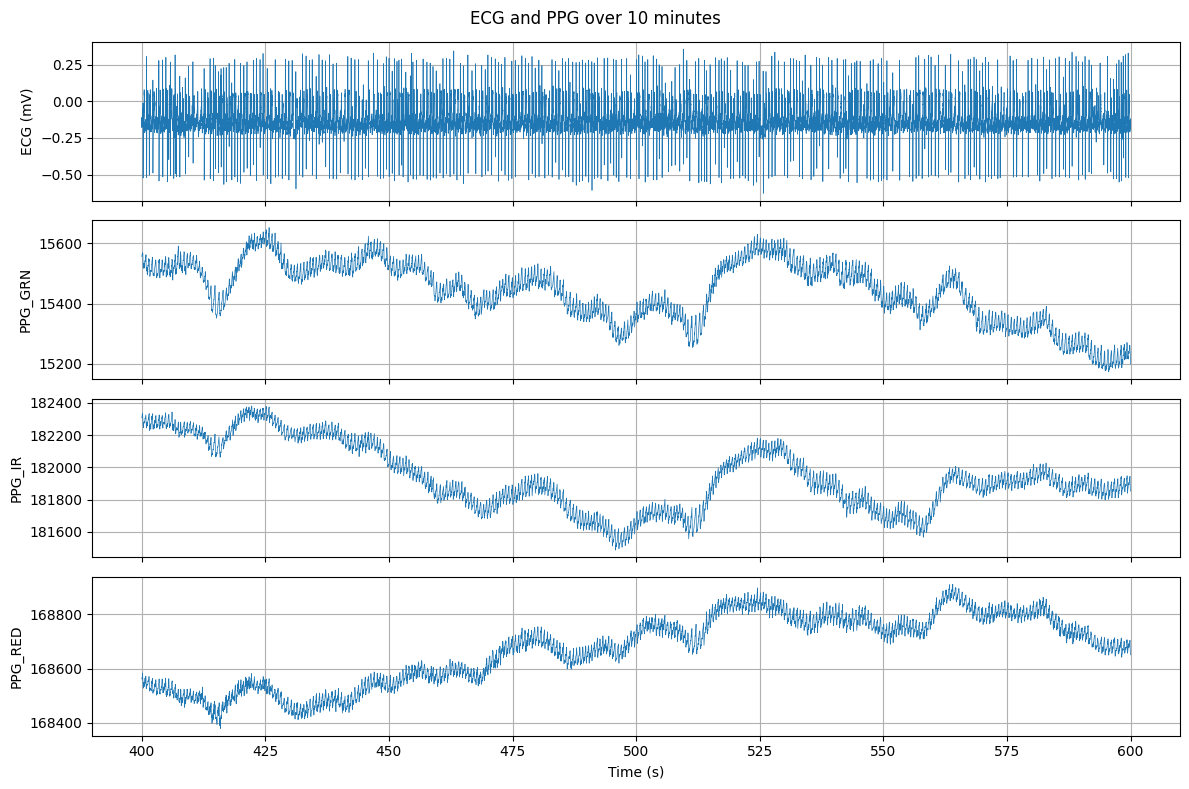

In [13]:
fig, axes = plt.subplots(len(streams), 1, sharex=True, figsize=(12, 8))

if len(streams) == 1:
    axes = [axes]  # handle edge case

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    srate = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]  # normalize to start at 0
    print(1.0 / np.mean(np.diff(timestamps)))
    mask = (400 <= timestamps) & (timestamps <= 600)
    timestamps = timestamps[mask]
    data = data[mask]

    if name == "ECG_Stream":
        # For ECG, convert to mV assuming 12-bit ADC, 3.3V reference and gain of 1100
        data = (((data / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
    
    print(f"{name}: {data.shape}, {srate} Hz")

    # If multichannel, plot first channel (change if needed)
    if data.ndim > 1:
        data = data[:, 0]

    axes[idx].plot(timestamps, data, linewidth=0.5)
    axes[idx].set_ylabel("ECG (mV)" if name == "ECG_Stream" else name)
    axes[idx].grid(True)

axes[-1].set_xlabel("Time (s)")

plt.suptitle("ECG and PPG over 10 minutes")
plt.tight_layout()
plt.show()

In [8]:
import neurokit2 as nk

def estimate_fs(timestamps):
    return 1.0 / np.mean(np.diff(timestamps))

def select_time_window(t, x, t_start, t_end):
    """Select a time window from t_start to t_end."""
    mask = (t >= t_start) & (t <= t_end)
    return t[mask], x[mask]

def find_peaks(signal, timestamps, signal_type="ecg"):
    """Clean signal and detect peaks using NeuroKit2."""
    fs = estimate_fs(timestamps)

    if signal_type == "ecg":
        cleaned = nk.ecg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ecg_peaks(cleaned, sampling_rate=fs)
        # peaks is a DataFrame column: 1 where a peak exists
        peak_times = timestamps[peaks['ECG_R_Peaks'].values.astype(bool)]
    elif signal_type == "ppg":
        cleaned = nk.ppg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ppg_peaks(cleaned, sampling_rate=fs)
        peak_times = timestamps[peaks['PPG_Peaks'].values.astype(bool)]
    else:
        raise ValueError("signal_type must be 'ecg' or 'ppg'")

    return cleaned, peak_times

def compute_hr_hrv(signal, timestamps, signal_type):
    """
    signal_type: "ecg" or "ppg"
    """
    fs = estimate_fs(timestamps)

    if signal_type == "ecg":
        cleaned = nk.ecg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ecg_peaks(cleaned, sampling_rate=fs, method="promac", show=True)
        rate = nk.ecg_rate(peaks, sampling_rate=fs)

    elif signal_type == "ppg":
        cleaned = nk.ppg_clean(signal, sampling_rate=fs)
        peaks, info = nk.ppg_peaks(cleaned, sampling_rate=fs, show=True)
        rate = nk.ppg_rate(peaks, sampling_rate=fs)

    else:
        raise ValueError("signal_type must be 'ecg' or 'ppg'")

    # HRV metrics from detected peaks
    hrv = nk.hrv(peaks, sampling_rate=fs, show=False)

    return {
        "fs": fs,
        "cleaned": cleaned,
        "peaks": peaks,
        "rate": rate,
        "hrv": hrv
    }

611.8224602847541
24.943347020553386
24.94334581128932
24.943346321230997


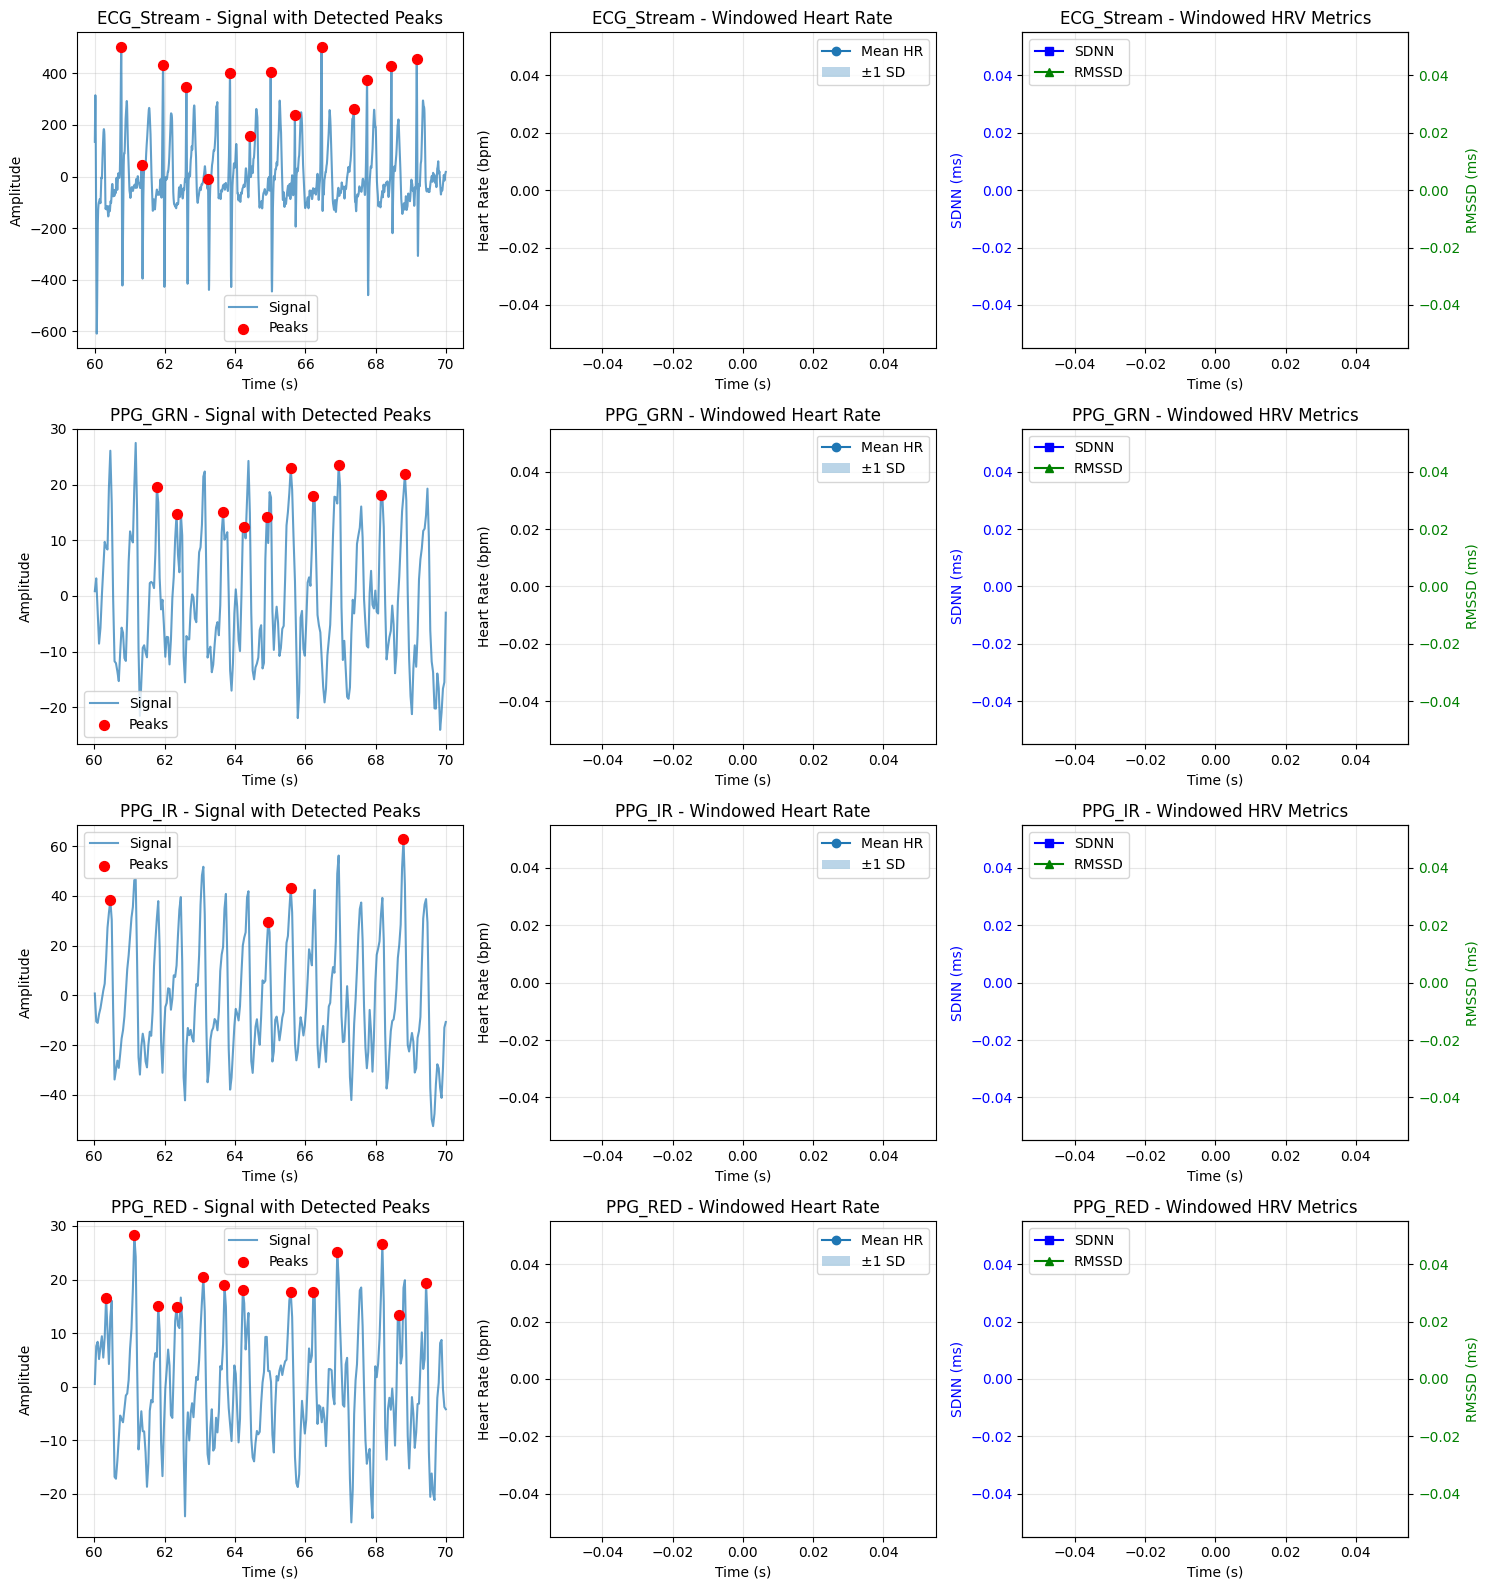


=== Summary Statistics ===

ECG_Stream:
  Mean HR: nan ± nan bpm
  Mean SDNN: nan ± nan ms
  Mean RMSSD: nan ± nan ms

PPG_GRN:
  Mean HR: nan ± nan bpm
  Mean SDNN: nan ± nan ms
  Mean RMSSD: nan ± nan ms

PPG_IR:
  Mean HR: nan ± nan bpm
  Mean SDNN: nan ± nan ms
  Mean RMSSD: nan ± nan ms

PPG_RED:
  Mean HR: nan ± nan bpm
  Mean SDNN: nan ± nan ms
  Mean RMSSD: nan ± nan ms


C:\Users\sanra\AppData\Local\Temp\ipykernel_36824\3356398321.py:173: RuntimeWarning: Mean of empty slice
  print(f"  Mean HR: {np.nanmean(res['hr_mean']):.1f} ± {np.nanstd(res['hr_mean']):.1f} bpm")
c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\sanra\AppData\Local\Temp\ipykernel_36824\3356398321.py:174: RuntimeWarning: Mean of empty slice
  print(f"  Mean SDNN: {np.nanmean(res['sdnn']):.1f} ± {np.nanstd(res['sdnn']):.1f} ms")
C:\Users\sanra\AppData\Local\Temp\ipykernel_36824\3356398321.py:175: RuntimeWarning: Mean of empty slice
  print(f"  Mean RMSSD: {np.nanmean(res['rmssd']):.1f} ± {np.nanstd(res['rmssd']):.1f} ms")


In [5]:
t_start = 60
t_end = 70

results = {}

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]  # normalize to start at 0

    fs = estimate_fs(timestamps)
    print(fs)
    
    # select time window
    t_win, x_win = select_time_window(timestamps, data, t_start, t_end)
    
    # detect peaks
    cleaned, peak_times = find_peaks(x_win, t_win, signal_type="ecg" if "ECG" in name.upper() else "ppg")
    
    # Convert peak_times to indices
    peak_indices = np.searchsorted(t_win, peak_times)
    peak_indices = peak_indices[peak_indices < len(cleaned)]
    
    # Create binary peaks array
    peaks = np.zeros(len(cleaned), dtype=int)
    peaks[peak_indices] = 1
    
    # Calculate HR from RR intervals
    if len(peak_indices) > 1:
        # Calculate RR intervals in samples
        rr_samples = np.diff(peak_indices)
        # Convert to HR in bpm
        rr_seconds = rr_samples / fs
        instantaneous_hr = 60.0 / rr_seconds
        
        # Create HR series by interpolating
        hr_series = np.zeros(len(cleaned))
        hr_series[:] = np.nan
        
        # Assign HR values between peaks
        for i in range(len(peak_indices) - 1):
            start = peak_indices[i]
            end = peak_indices[i + 1]
            hr_series[start:end] = instantaneous_hr[i]
        
        # Forward fill the last segment
        if len(peak_indices) > 0:
            hr_series[peak_indices[-1]:] = instantaneous_hr[-1] if len(instantaneous_hr) > 0 else np.nan
    else:
        hr_series = np.full(len(cleaned), np.nan)
    
    window_size = 100.0  # seconds
    step_size = 1.0     # seconds
    
    # Calculate number of samples for window and step
    window_samples = int(window_size * fs)
    step_samples = int(step_size * fs)
    
    # Initialize lists to store windowed metrics
    window_times = []
    hr_mean = []
    hr_std = []
    sdnn_values = []
    rmssd_values = []
    
    # Sliding window analysis
    start_idx = 0
    while start_idx + window_samples <= len(cleaned):
        end_idx = start_idx + window_samples
        
        # Get peaks in current window
        window_peaks = peaks[start_idx:end_idx]
        peak_idx_in_window = np.where(window_peaks == 1)[0]
        
        # Calculate window center time
        window_center = t_win[start_idx] + window_size / 2
        window_times.append(window_center)
        
        # Calculate HR metrics
        if len(peak_idx_in_window) > 1:
            hr_window = hr_series[start_idx:end_idx]
            hr_mean.append(np.nanmean(hr_window))
            hr_std.append(np.nanstd(hr_window))
            
            # Calculate RR intervals (in ms)
            rr_intervals = np.diff(peak_idx_in_window) / fs * 1000
            
            # Calculate HRV metrics
            if len(rr_intervals) > 1:
                sdnn_values.append(np.std(rr_intervals, ddof=1))
                rmssd_values.append(np.sqrt(np.mean(np.diff(rr_intervals)**2)))
            else:
                sdnn_values.append(np.nan)
                rmssd_values.append(np.nan)
        else:
            hr_mean.append(np.nan)
            hr_std.append(np.nan)
            sdnn_values.append(np.nan)
            rmssd_values.append(np.nan)
        
        start_idx += step_samples
    
    # Store results
    results[name] = {
        'timestamps': t_win,
        'cleaned_signal': cleaned,
        'peaks': peaks,
        'hr_series': hr_series,
        'window_times': np.array(window_times),
        'hr_mean': np.array(hr_mean),
        'hr_std': np.array(hr_std),
        'sdnn': np.array(sdnn_values),
        'rmssd': np.array(rmssd_values)
    }

# Plotting
n_streams = len(results)
fig, axes = plt.subplots(n_streams, 3, figsize=(15, 4*n_streams))
if n_streams == 1:
    axes = axes.reshape(1, -1)

for idx, (name, res) in enumerate(results.items()):
    # Plot 1: Signal with peaks
    axes[idx, 0].plot(res['timestamps'], res['cleaned_signal'], label='Signal', alpha=0.7)
    peak_times_plot = res['timestamps'][res['peaks'] == 1]
    peak_values_plot = res['cleaned_signal'][res['peaks'] == 1]
    axes[idx, 0].scatter(peak_times_plot, peak_values_plot, c='red', s=50, zorder=5, label='Peaks')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].set_title(f'{name} - Signal with Detected Peaks')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot 2: Windowed HR
    axes[idx, 1].plot(res['window_times'], res['hr_mean'], marker='o', label='Mean HR')
    axes[idx, 1].fill_between(res['window_times'], 
                              res['hr_mean'] - res['hr_std'], 
                              res['hr_mean'] + res['hr_std'], 
                              alpha=0.3, label='±1 SD')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Heart Rate (bpm)')
    axes[idx, 1].set_title(f'{name} - Windowed Heart Rate')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Plot 3: Windowed HRV
    ax3 = axes[idx, 2]
    ax3.plot(res['window_times'], res['sdnn'], marker='s', label='SDNN', color='blue')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('SDNN (ms)', color='blue')
    ax3.tick_params(axis='y', labelcolor='blue')
    ax3.set_title(f'{name} - Windowed HRV Metrics')
    ax3.grid(True, alpha=0.3)
    
    ax3_twin = ax3.twinx()
    ax3_twin.plot(res['window_times'], res['rmssd'], marker='^', label='RMSSD', color='green')
    ax3_twin.set_ylabel('RMSSD (ms)', color='green')
    ax3_twin.tick_params(axis='y', labelcolor='green')
    
    # Add legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Mean HR: {np.nanmean(res['hr_mean']):.1f} ± {np.nanstd(res['hr_mean']):.1f} bpm")
    print(f"  Mean SDNN: {np.nanmean(res['sdnn']):.1f} ± {np.nanstd(res['sdnn']):.1f} ms")
    print(f"  Mean RMSSD: {np.nanmean(res['rmssd']):.1f} ± {np.nanstd(res['rmssd']):.1f} ms")


['zong error: `pad_width` must be of integral type.']


c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:536: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\neurokit2\complexity\entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapezoid(mse) / len(mse)
c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:134: RuntimeWarning: divide by zero encountered in divide
  normalization = (n - 1) / (np.floor((n - k_subrange) / k).astype(int) * k)
c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\neurokit2\complexity\optim_complexity_k.py:135: RuntimeWarni


ECG_Stream HR/HRV metrics:
Rate: 98.57783758202632
   HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_pNN50  HRV_LF  HRV_HF  HRV_LFHF
0  633.470416  131.084491  187.849288  64.285714     NaN     NaN       NaN

PPG_GRN HR/HRV metrics:
Rate: 82.47326822054407
   HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_pNN50  HRV_LF  HRV_HF  HRV_LFHF
0  783.998857  277.113858  449.348513  55.555556     NaN     NaN       NaN

PPG_IR HR/HRV metrics:
Rate: 36.79828763898878
    HRV_MeanNN     HRV_SDNN    HRV_RMSSD  HRV_pNN50  HRV_LF  HRV_HF  HRV_LFHF
0  2779.632446  1959.673244  3270.784635  66.666667     NaN     NaN       NaN

PPG_RED HR/HRV metrics:
Rate: 86.66257587464672
   HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_pNN50  HRV_LF  HRV_HF  HRV_LFHF
0  758.385279  283.205804  471.426018  83.333333     NaN     NaN       NaN


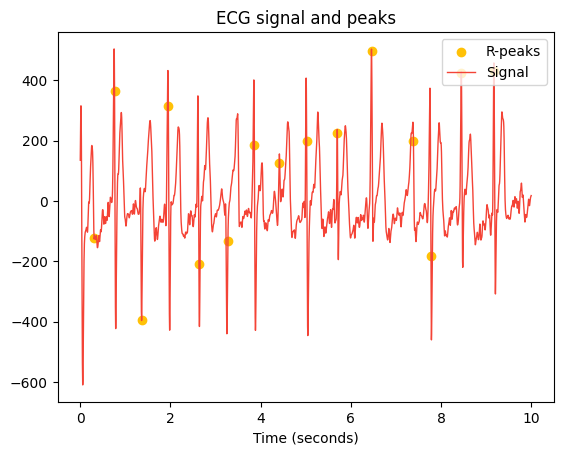

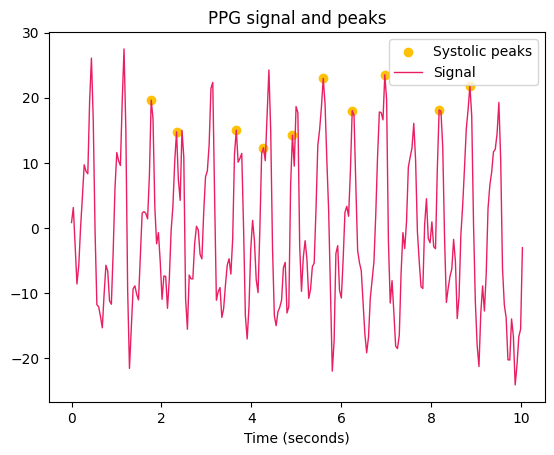

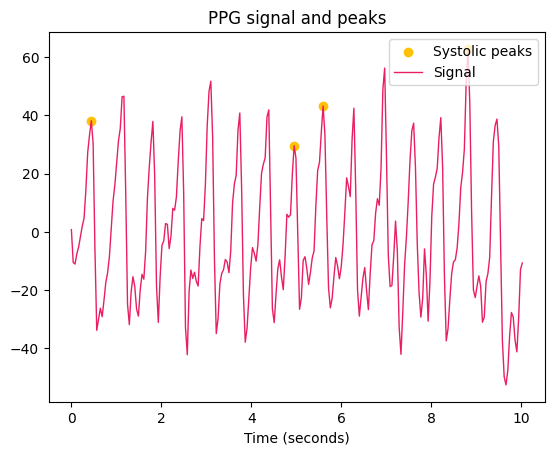

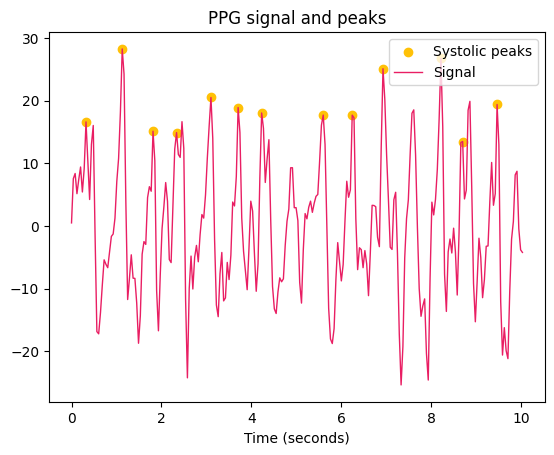

In [6]:
results = {}

np.trapezoid = np.trapz

for idx, stream in enumerate(streams):
    name = stream['info']['name'][0]
    srate = float(stream['info']['nominal_srate'][0])

    data = np.array(stream['time_series'])
    timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]

    mask = (60 <= timestamps) & (timestamps <= 70)
    timestamps = timestamps[mask]
    data = data[mask]

    results[name] = compute_hr_hrv(data, 
                                   timestamps, 
                                   signal_type="ecg" if "ECG" in name.upper() else "ppg"
                                   )

for name, res in results.items():
    print(f"\n{name} HR/HRV metrics:")
    print("Rate:", np.average(res["rate"]))
    print(res["hrv"][[
        "HRV_MeanNN",
        "HRV_SDNN",
        "HRV_RMSSD",
        "HRV_pNN50",
        "HRV_LF",
        "HRV_HF",
        "HRV_LFHF"
    ]])

In [18]:
stream = streams[0]
data = np.array(stream['time_series']).flatten()
ecg = (((data / 4096 * 3.3) - (3.3 / 2)) / 1100) * 1000
timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]

mask = (60 <= timestamps) & (timestamps <= 60*21)
timestamps = timestamps[mask]
ecg = ecg[mask]

In [ ]:
signals, info = nk.ecg_process(ecg, sampling_rate=estimate_fs(timestamps))

nk.ecg_plot(signals, info)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >], dtype=object)

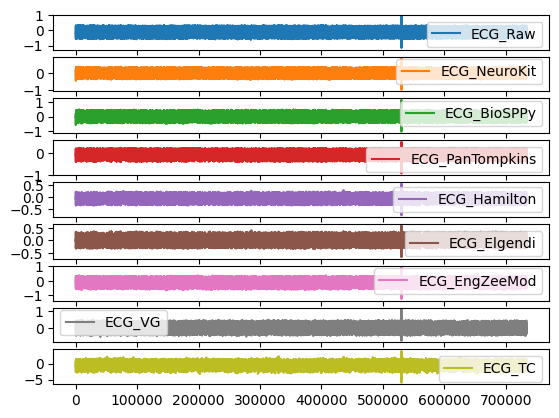

In [12]:
import pandas as pd

signals = pd.DataFrame({
    "ECG_Raw" : ecg,
    "ECG_NeuroKit" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="neurokit"),
    "ECG_BioSPPy" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="biosppy"),
    "ECG_PanTompkins" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="pantompkins1985"),
    "ECG_Hamilton" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="hamilton2002"),
    "ECG_Elgendi" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="elgendi2010"),
    "ECG_EngZeeMod" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="engzeemod2012"),
    "ECG_VG" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="vg"),
    "ECG_TC" : nk.ecg_clean(ecg, sampling_rate=estimate_fs(timestamps), method="templateconvolution")
})

signals.plot(subplots=True)

In [3]:
import heartpy as hp

def compute_hr_hrv_hp(signal, sample_rate, clean=True):
    signal = np.asarray(signal)

    if clean:
        signal = hp.filter_signal(
            signal,
            cutoff=0.5,
            sample_rate=sample_rate,
            filtertype='highpass'
        )

    wd, m = hp.process(
        signal,
        sample_rate=sample_rate,
        clean_rr=True
    )

    results = {
        "hr_bpm": m.get("bpm", np.nan),
        "ibi_ms": m.get("ibi", np.nan),
        "sdnn_ms": m.get("sdnn", np.nan),
        "rmssd_ms": m.get("rmssd", np.nan),
        "pnn20": m.get("pnn20", np.nan),
        "pnn50": m.get("pnn50", np.nan),
        "triangular_index": m.get("triangular_index", np.nan),
        "breathing_rate_hz": m.get("breathingrate", np.nan),
        "n_beats": len(wd.get("peaklist", []))
    }

    return results, wd

results, wd = compute_hr_hrv_hp(ecg, estimate_fs(timestamps))
print(results)

c:\Users\sanra\OneDrive\Documents\Research\ECG_viewer\venv\Lib\site-packages\heartpy\datautils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


NameError: name 'ecg' is not defined

In [4]:
import heartpy as hp

def rolling_hrv_60s(signal, fs, step_sec=1):
    """
    Compute 60s rolling HRV using HeartPy.

    Returns
    -------
    times : np.ndarray (seconds)
    rmssd : np.ndarray
    sdnn : np.ndarray
    hr : np.ndarray
    """
    win_size = int(60*5 * fs)
    step_size = int(step_sec * fs)

    times = []
    rmssd = []
    sdnn = []
    hr = []

    for start in range(0, len(signal) - win_size, step_size):
        end = start + win_size
        window = signal[start:end]

        try:
            wd, m = hp.process(
                window,
                sample_rate=fs,
                clean_rr=True
            )

            times.append(start / fs)
            rmssd.append(m.get("rmssd", np.nan))
            sdnn.append(m.get("sdnn", np.nan))
            hr.append(m.get("bpm", np.nan))

        except Exception:
            # window failed → keep alignment
            times.append(start / fs)
            rmssd.append(np.nan)
            sdnn.append(np.nan)
            hr.append(np.nan)

    return (
        np.array(times),
        np.array(rmssd),
        np.array(sdnn),
        np.array(hr)
    )

C:\Users\sanra\AppData\Local\Temp\ipykernel_7972\4221179796.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


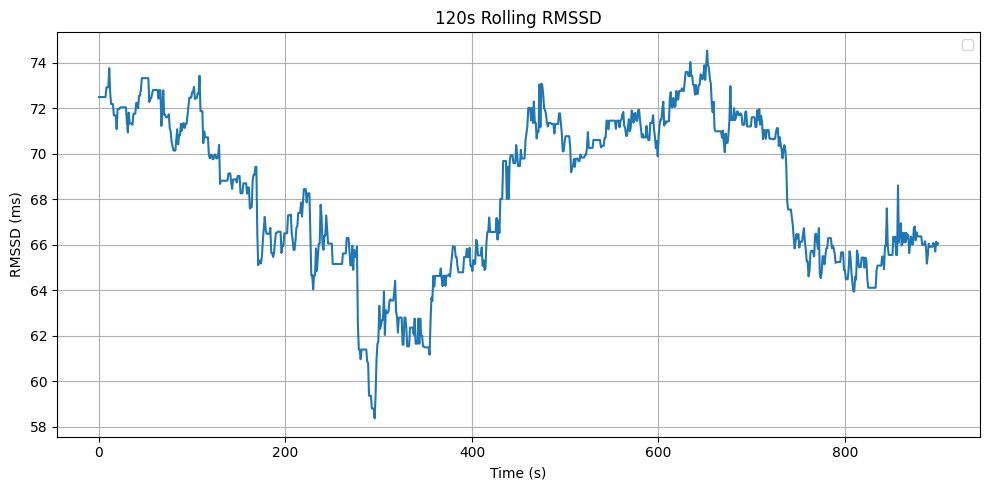

In [20]:
t, rmssd, sdnn, hr = rolling_hrv_60s(ecg, estimate_fs(timestamps))

plt.figure(figsize=(10, 5))

plt.plot(t, rmssd)

plt.xlabel("Time (s)")
plt.ylabel("RMSSD (ms)")
plt.title("120s Rolling RMSSD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\sanra\AppData\Local\Temp\ipykernel_7972\447684314.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


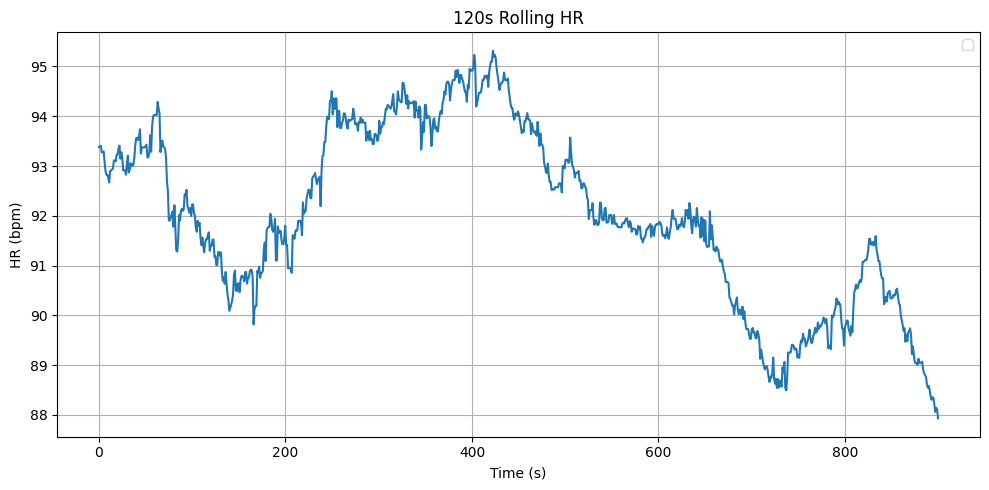

In [21]:
plt.figure(figsize=(10, 5))

plt.plot(t, hr)

plt.xlabel("Time (s)")
plt.ylabel("HR (bpm)")
plt.title("120s Rolling HR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
stream = streams[1] # PPG Green
ppg = np.array(stream['time_series']).flatten()
timestamps = np.array(stream['time_stamps']) - stream['time_stamps'][0]

mask = (60 <= timestamps) & (timestamps <= 60*21)
timestamps = timestamps[mask]
ppg = ppg[mask]

In [13]:
def rolling_hrv_60s_ppg(signal, fs, step_sec=1):
    """
    60s rolling HRV for PPG signals using HeartPy.

    Returns
    -------
    times : np.ndarray (seconds)
    rmssd : np.ndarray (ms)
    sdnn : np.ndarray (ms)
    hr : np.ndarray (bpm)
    """
    win_size = int(60*5 * fs)
    step_size = int(step_sec * fs)

    times, rmssd, sdnn, hr = [], [], [], []

    # PPG-specific preprocessing
    try:
        filtered = hp.filter_signal(
            signal,
            cutoff=[0.5, 8.0],   # PPG band
            sample_rate=fs,
            filtertype='bandpass'
        )
    except Exception:
        filtered = signal.copy()

    for start in range(0, len(filtered) - win_size, step_size):
        end = start + win_size
        window = filtered[start:end]

        try:
            wd, m = hp.process(
                window,
                sample_rate=fs,
                bpmmin=40,
                bpmmax=200,
                clean_rr=True,
                reject_segmentwise=False
            )

            times.append(start / fs)
            rmssd.append(m.get("rmssd", np.nan))
            sdnn.append(m.get("sdnn", np.nan))
            hr.append(m.get("bpm", np.nan))

        except Exception:
            times.append(start / fs)
            rmssd.append(np.nan)
            sdnn.append(np.nan)
            hr.append(np.nan)

    return (
        np.array(times),
        np.array(rmssd),
        np.array(sdnn),
        np.array(hr)
    )

In [ ]:
wd, _ = hp.process(
    hp.filter_signal(
        ppg,
        cutoff=[0.5, 8.0],
        sample_rate=estimate_fs(timestamps),
        filtertype='bandpass'
    ),
    sample_rate=estimate_fs(timestamps),
    bpmmin=40,
    bpmmax=200,
    clean_rr=True,
    reject_segmentwise=False
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(wd['filtered'])
plt.scatter(wd['peaklist'], wd['filtered'][wd['peaklist']], c='r')
plt.title("PPG Peak Detection Check")
plt.show()


KeyError: 'filtered'

<Figure size 640x480 with 0 Axes>

C:\Users\sanra\AppData\Local\Temp\ipykernel_3204\1208742713.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


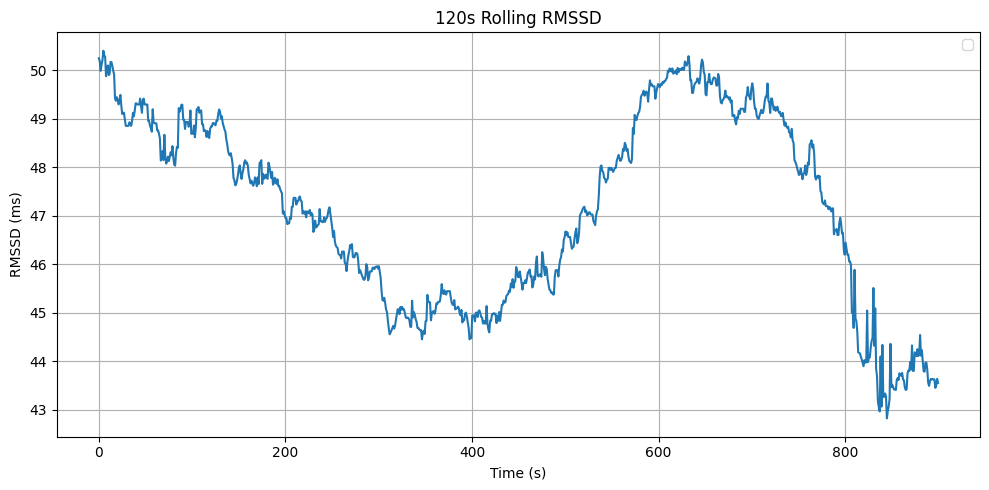

C:\Users\sanra\AppData\Local\Temp\ipykernel_3204\1208742713.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


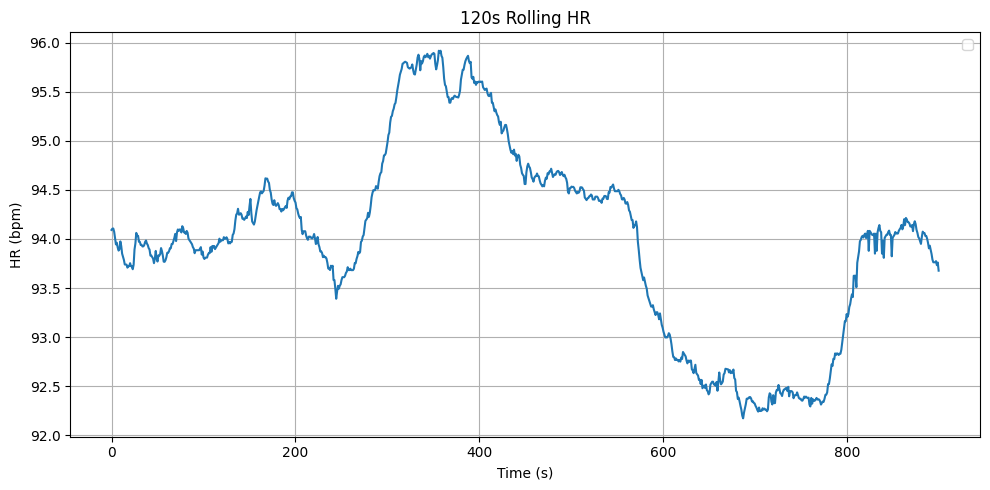

In [14]:
t, rmssd, sdnn, hr = rolling_hrv_60s_ppg(ppg, estimate_fs(timestamps))

plt.figure(figsize=(10, 5))

plt.plot(t, rmssd)

plt.xlabel("Time (s)")
plt.ylabel("RMSSD (ms)")
plt.title("120s Rolling RMSSD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

plt.plot(t, hr)

plt.xlabel("Time (s)")
plt.ylabel("HR (bpm)")
plt.title("120s Rolling HR")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()